In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import validation_curve
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc,roc_auc_score
import umap
from sklearn.inspection import permutation_importance
import os
import sklearn.cluster as cluster
import warnings
warnings.filterwarnings('ignore')
os.chdir('E:/final_dataset/')

In [2]:
data = pd.read_csv('CN_patchseq_Ephysi_metaInformation_integrated_20230207.csv')

In [3]:
data =data[data['recording'].isin(['good','ok'])]
data =data[data['Expert_label'].isin(['T-stellate','Bushy','Fusiform','Octopus'])]
data = data.fillna(0)

In [4]:
labels = ['Bushy','Fusiform','Octopus', 'T-stellate']
labels  = sorted(labels)

In [5]:
adata = data[[
'Tau (ms)', 
'SagRatio', 
'Rebound (mV)', 
'RM (Mohm)', 
'RMP (mV)',      
'RheoBase (pA)', 
'Spike Delay (ms)', 
'Threshold (mV)', 
'Amplitude (mV)',
'AHP (mV)', 
'Depolarization Time (ms)', 
'Repolarization Time (ms)',
'Half Width (ms)', 
'Max Spike Number', 
'AP Number @ 2xRheabase',
'Initial Adaptation', 'Last Adaptation',#'AP2_Diff',# 'AP3_Diff',
#'AP_End_Diff', 
#'Rebound_abs (mV)', 
#'Rebound_spikes',
'Spike_Delay @ 2xRheobase',
"Expert_label"]].copy()

In [6]:
X = adata.drop(['Expert_label'], axis=1)
para = list(X.columns)
X = RobustScaler().fit_transform(X)
y = adata['Expert_label']
print(f'x shape: {X.shape} | y shape: {y.shape} ')

x shape: (404, 18) | y shape: (404,) 


In [7]:
for name in labels:
    print(name, len(y[y == name]))

Bushy 243
Fusiform 36
Octopus 58
T-stellate 67


In [8]:
clf = RandomForestClassifier(n_estimators=100,random_state=0,bootstrap =True, n_jobs = 10)

In [9]:
random_state_n = []
n = 0
for i in range(0,10000,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if accuracy_score(y_test, y_pred) > 0.99:
        n  = n + 1
        random_state_n.append(i)
        if n == 100:
            break

In [11]:
cm = 0
train_score = 0
test_score = 0
fpr1 = pd.DataFrame()
tpr1 = pd.DataFrame()
fpr2 = pd.DataFrame()
tpr2 = pd.DataFrame()
fpr3 = pd.DataFrame()
tpr3 = pd.DataFrame()
fpr4 = pd.DataFrame()
tpr4 = pd.DataFrame()
importances = pd.DataFrame(index = para,columns = ['importances'])
importances['importances'] = 0.0
k = 0
for i in random_state_n:
    #print(k+1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    cm = cm+matrix
    ###Learning Curve
    train_sizes =  np.arange(0.1,1,0.05)
    sizes, training_scores, testing_scores = learning_curve(clf, X_train, y_train,
                                                            scoring='accuracy', train_sizes=train_sizes)
    mean_training = np.mean(training_scores, axis=1)
    train_score = train_score+mean_training
    Standard_Deviation_training = np.std(training_scores, axis=1)
    mean_testing = np.mean(testing_scores, axis=1)
    test_score = test_score + mean_testing
    Standard_Deviation_testing = np.std(testing_scores, axis=1)
    ###Freature importance
    importance = pd.DataFrame(clf.feature_importances_,index = para,columns = ['importances'])
    importances  = importances + importance
    ###ROC curve
    pred_prob = clf.predict_proba(X_test)
    fpr = {}
    tpr = {}
    thresh ={}
    n_class =['Bushy', 'T-stellate', 'Octopus', 'Fusiform']
    for j in range(4):    
        fpr[j], tpr[j], thresh[j] = roc_curve(y_test, pred_prob[:,j], pos_label=n_class[j])
    fpr1[k] = pd.DataFrame(fpr[0])
    tpr1[k] = pd.DataFrame(tpr[0])
    fpr2[k] = pd.DataFrame(fpr[1])
    tpr2[k] = pd.DataFrame(tpr[1])
    fpr3[k] = pd.DataFrame(fpr[2])
    tpr3[k] = pd.DataFrame(tpr[2])
    fpr4[k] = pd.DataFrame(fpr[3])
    tpr4[k] = pd.DataFrame(tpr[3])
    k=k+1

In [ ]:
Bushy 12160 / 12198 99.69%
Fusiform 1632 / 1644 99.27%
Octopus 2876 / 2935 97.99%
T-stellate 3362 / 3423 98.22%
99.16%

In [12]:
true_n = 0
total_n=0 

for i in range(0,4,1):
    print(labels[i],cm[i,i],'/',sum(cm[:,i]), str('%.2f'%(cm[i,i]/sum(cm[:,i])*100.0))+'%')
    true_n = true_n + cm[i,i]
    total_n = total_n + sum(cm[:,i])   
    acur_rate = true_n/total_n*100.0

print(str('%.2f'%(acur_rate))+'%')

Bushy 12160 / 12198 99.69%
Fusiform 1632 / 1644 99.27%
Octopus 2876 / 2935 97.99%
T-stellate 3362 / 3423 98.22%
99.16%


Text(20.72222222222222, 0.5, 'Expert Label')

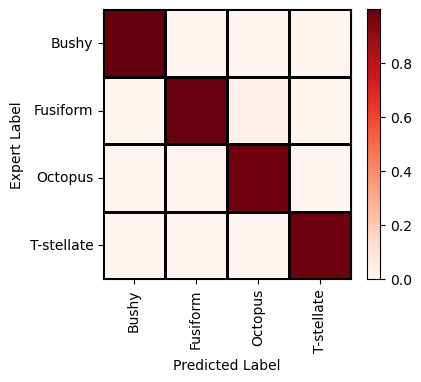

In [13]:
cm = cm.astype(np.float32)
for i in range(0,4,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
rcParams['figure.figsize'] = 4, 3.5
ax = sns.heatmap(cm, cmap='Reds',cbar=True,
                 linewidths=1, linecolor='black'#,annot = True, annot_kws = {'size':14},fmt='0.3f'
                )
sns.despine(top = False, right = False, left = False,bottom = False)  
ax.set_xticklabels(['Bushy','Fusiform','Octopus', 'T-stellate'])
ax.set_yticklabels(['Bushy','Fusiform','Octopus', 'T-stellate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)

plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')
#plt.savefig('ExN_E_cluster_ML_Matrix.pdf',dpi = 300)

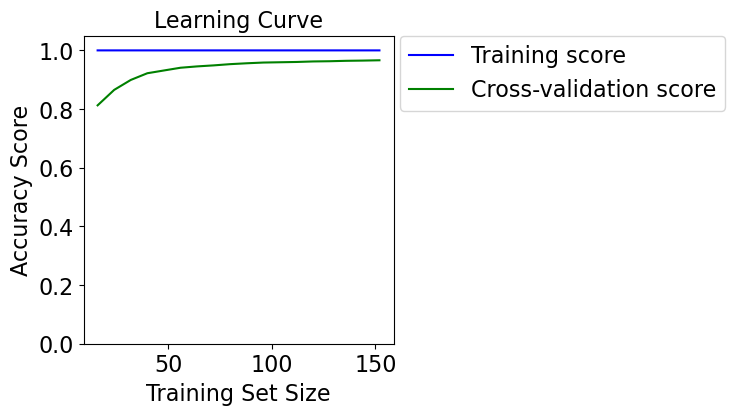

In [15]:
rcParams['figure.figsize'] = 4, 4     
# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, train_score/100, color="b",  label="Training score")
plt.plot(sizes, test_score/100, color="g", label="Cross-validation score")
plt.ylim(0.0, 1.05)
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.tight_layout()
plt.savefig('ExN_E_cluster_Learning Curve.pdf',dpi = 300)

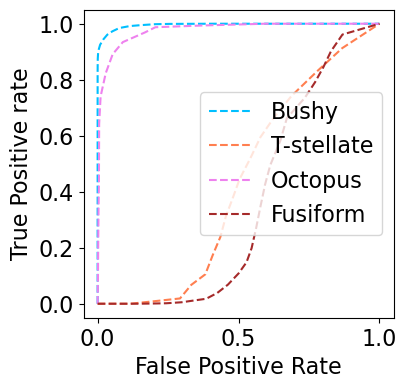

In [16]:
plt.plot(fpr1.mean(axis=1)/max(fpr1.mean(axis=1)), 
         tpr1.mean(axis=1)/max(tpr1.mean(axis=1)),
         linestyle='--',color='deepskyblue', label=n_class[0])
plt.plot(fpr2.mean(axis=1)/max(fpr2.mean(axis=1)), 
         tpr2.mean(axis=1)/max(tpr2.mean(axis=1)), 
         linestyle='--',color='coral', label=n_class[1])
plt.plot(fpr3.mean(axis=1)/max(fpr3.mean(axis=1)), 
         tpr3.mean(axis=1)/max(tpr3.mean(axis=1)), 
         linestyle='--',color='violet', label=n_class[2])
plt.plot(fpr4.mean(axis=1)/max(fpr4.mean(axis=1)), 
         tpr4.mean(axis=1)/max(tpr4.mean(axis=1)), 
         linestyle='--',color='brown', label=n_class[3])
rcParams['figure.figsize'] = 4, 4
#plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.show()
#plt.savefig('ExN_E_ROC.pdf',dpi = 300)

<AxesSubplot:xlabel='importances'>

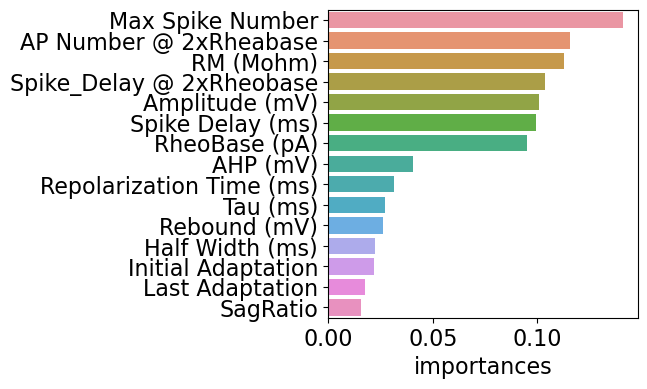

In [17]:
importances = importances.sort_values(by=['importances'],ascending=False)
rcParams['figure.figsize'] = 4, 4
sns.barplot(x= importances['importances'].iloc[0:15]/100, y = list(importances.index)[0:15])
#plt.savefig('ExN_E_importances.pdf',dpi = 300)

In [18]:
selected_var = importances.iloc[0:15]
var_name = list(selected_var.index)
adata = data[var_name].values
scaled_adata = StandardScaler().fit_transform(adata)
scaled_adata = pd.DataFrame(scaled_adata,columns= var_name)
for par in var_name:
    scaled_adata[par] = scaled_adata[par]*importances.loc[par]['importances']
scaled_adata = scaled_adata.values
reducer = umap.UMAP(random_state =1,min_dist = 0.4)
embedding = reducer.fit_transform(scaled_adata)

([], [])

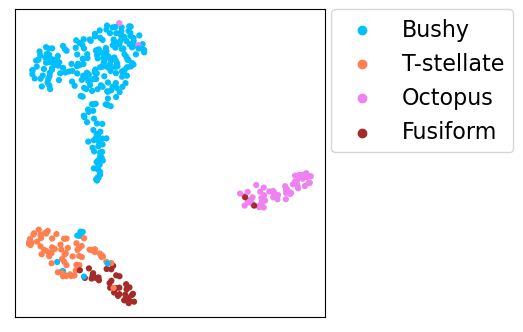

In [19]:
rcParams['figure.figsize'] = 4, 4
palette = {'Bushy': 'deepskyblue', 
           'Octopus': 'violet',
           'Fusiform': 'brown',
           'T-stellate': 'coral'
          }
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = y, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])
#plt.savefig('ExN_E_cluster_true_label.pdf',dpi = 300)

([], [])

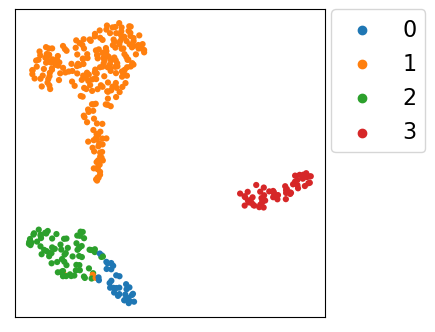

In [20]:
kmeans_labels = cluster.KMeans(n_clusters=4,random_state=1).fit_predict(scaled_adata)


rcParams['figure.figsize'] = 4, 4
# palette = {'Bushy': 'deepskyblue', 
#            'Octopus': 'violet',
#            'Fusiform': 'brown',
#            'T-stellate': 'coral'
#           }
palette = 'tab10'
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = kmeans_labels, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks([])
plt.yticks([])
#plt.savefig('ExN_E_cluster_pred_label.pdf',dpi = 300)

Bushy 234 / 238 98.32%
Fusiform 27 / 33 81.82%
Octopus 56 / 58 96.55%
T-stellate 62 / 75 82.67%
93.81%


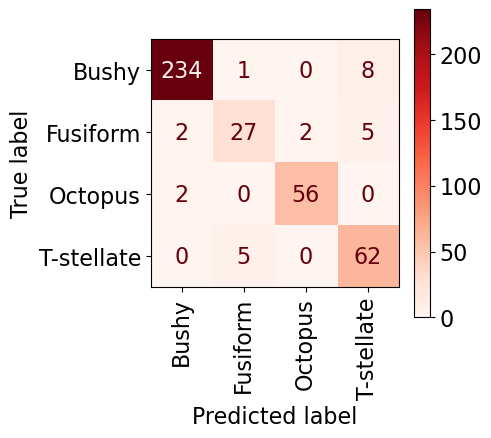

In [21]:

pred_labs = kmeans_labels.astype('object')
x_true = data.Expert_label
df = pd.DataFrame()
df['Expert_label'] =  x_true
df['pred'] = kmeans_labels
for i in range(0,kmeans_labels.max()+1,1):
    pred_labs[pred_labs == i] = df[df['pred'] == i].groupby(by = ['Expert_label']).count()['pred'].idxmax()

y_pred = pred_labs
cm = confusion_matrix(x_true, y_pred,#normalize = 'pred'
                     )

labels = ['Bushy','Fusiform','Octopus', 'T-stellate']
labels  = sorted(labels)
ax = ConfusionMatrixDisplay(cm, display_labels=labels)
ax.plot(cmap = 'Reds',xticks_rotation='vertical', include_values =True)

true_n = 0
total_n = 0
for i in range(0,4,1):
    print(labels[i],cm[i,i],'/',sum(cm[:,i]), str('%.2f'%(cm[i,i]/sum(cm[:,i])*100.0))+'%')
    true_n = true_n + cm[i,i]
    total_n = total_n + sum(cm[:,i])   

    acur_rate = true_n/total_n*100.0

print(str('%.2f'%(acur_rate))+'%')

([], [])

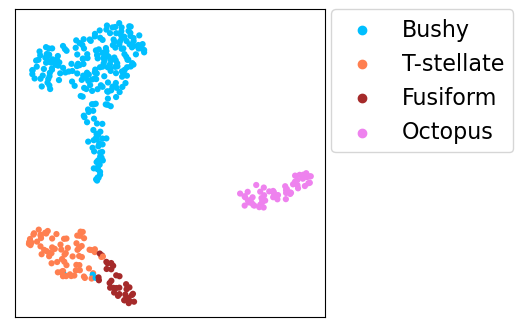

In [22]:
rcParams['figure.figsize'] = 4, 4
palette = {'Bushy': 'deepskyblue', 
           'Octopus': 'violet',
           'Fusiform': 'brown',
           'T-stellate': 'coral'
          }

sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = pred_labs, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])
#plt.savefig('ExN_E_cluster_pred_label.pdf',dpi = 300)

Text(11.722222222222223, 0.5, 'Expert Label')

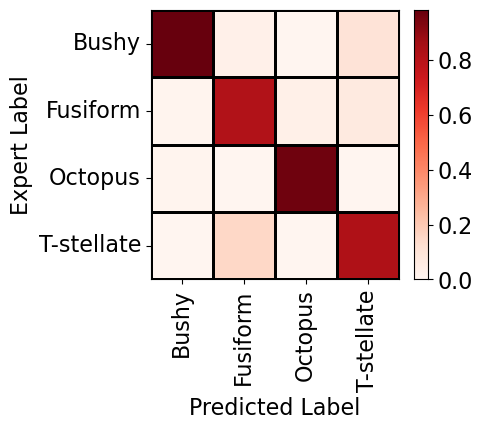

In [23]:
cm = cm.astype(np.float32)
for i in range(0,4,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
rcParams['figure.figsize'] = 4, 3.5
ax = sns.heatmap(cm, cmap='Reds',cbar=True,
                 linewidths=1, linecolor='black'#,annot = True, annot_kws = {'size':14},fmt='0.3f'
                )
sns.despine(top = False, right = False, left = False,bottom = False)  
ax.set_xticklabels(['Bushy','Fusiform','Octopus', 'T-stellate'])
ax.set_yticklabels(['Bushy','Fusiform','Octopus', 'T-stellate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)

plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')
#plt.savefig('ExN_E_cluster_Matrix.pdf',dpi = 300)

In [24]:
data['Ephysi_umapX'] = embedding[:, 0]
data['Ephysi_umapY'] = embedding[:, 1]
data['Ephysi_Pred'] = pred_labs

([], [])

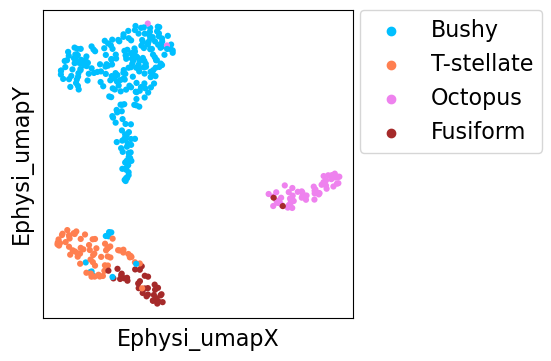

In [25]:
rcParams['figure.figsize'] = 4, 4
sns.scatterplot(x=data['Ephysi_umapX'], y= data['Ephysi_umapY'],
                hue = data['Expert_label'], s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])

In [35]:
data.to_csv('ExN_Ephysi_classifier.csv',index = False)